In [1]:
# Hre's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-05-17 05:32:12.092687: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12


In [3]:
# train = '/workspace/Attention/Data/Data_blance/Train'
# valid = '/workspace/Attention/Data/Data_blance/Val'
# test = '/workspace/Attention/Data/Data_blance/Test'

In [4]:
import pathlib

# Define the paths to the training and validation data directories
train_data_dir = pathlib.Path('/workspace/Attention/Data/Data_blance/Train')
valid_data_dir = pathlib.Path('/workspace/Attention/Data/Data_blance/Val')
test_data_dir = pathlib.Path('/workspace/Attention/Data/Data_blance/test')

In [5]:
# Define the batch size for training
batch_size = 32

# Define the image height and width for preprocessing
img_height = 180
img_width = 180

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for training and validation data
train_data_gen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1] range
valid_data_gen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1] range

# Generate batches of training data
train_data = train_data_gen.flow_from_directory(
    train_data_dir,             # Directory containing training images
    target_size=(img_height, img_width),  # Resize images to match the input size expected by the model
    batch_size=batch_size,      # Number of images per batch
    class_mode='categorical'         # Type of label, 'binary' for binary classification
)

# Generate batches of validation data
valid_data = valid_data_gen.flow_from_directory(
    valid_data_dir,             # Directory containing validation images
    target_size=(img_height, img_width),  # Resize images to match the input size expected by the model
    batch_size=batch_size,      # Number of images per batch
    class_mode='categorical'         # Type of label, 'binary' for binary classification
)
test_data = valid_data_gen.flow_from_directory(
    valid_data_dir,             # Directory containing validation images
    target_size=(img_height, img_width),  # Resize images to match the input size expected by the model
    batch_size=1,      # Number of images per batch
    class_mode='categorical'         # Type of label, 'binary' for binary classification
)

Found 3900 images belonging to 3 classes.
Found 279 images belonging to 3 classes.
Found 279 images belonging to 3 classes.


# *This code sets up data generators using ImageDataGenerator to load and preprocess images from directories. It rescales the pixel values of images to be in the range [0, 1].*

In [7]:
# Get the class names from the flow_from_directory method of train_data_gen
class_names = list(train_data_gen.flow_from_directory(
    train_data_dir,                 # Directory containing the training images
    target_size=(img_height, img_width),  # Resize images to this height and width
    batch_size=batch_size,         # Size of the batches during training
    class_mode='binary'            # Type of labels (binary classification)
).class_indices.keys())           # Extract class names from the class_indices dictionary

# Print the class names
print(class_names)

Found 3900 images belonging to 3 classes.
['Normal', 'bacteria', 'virus']


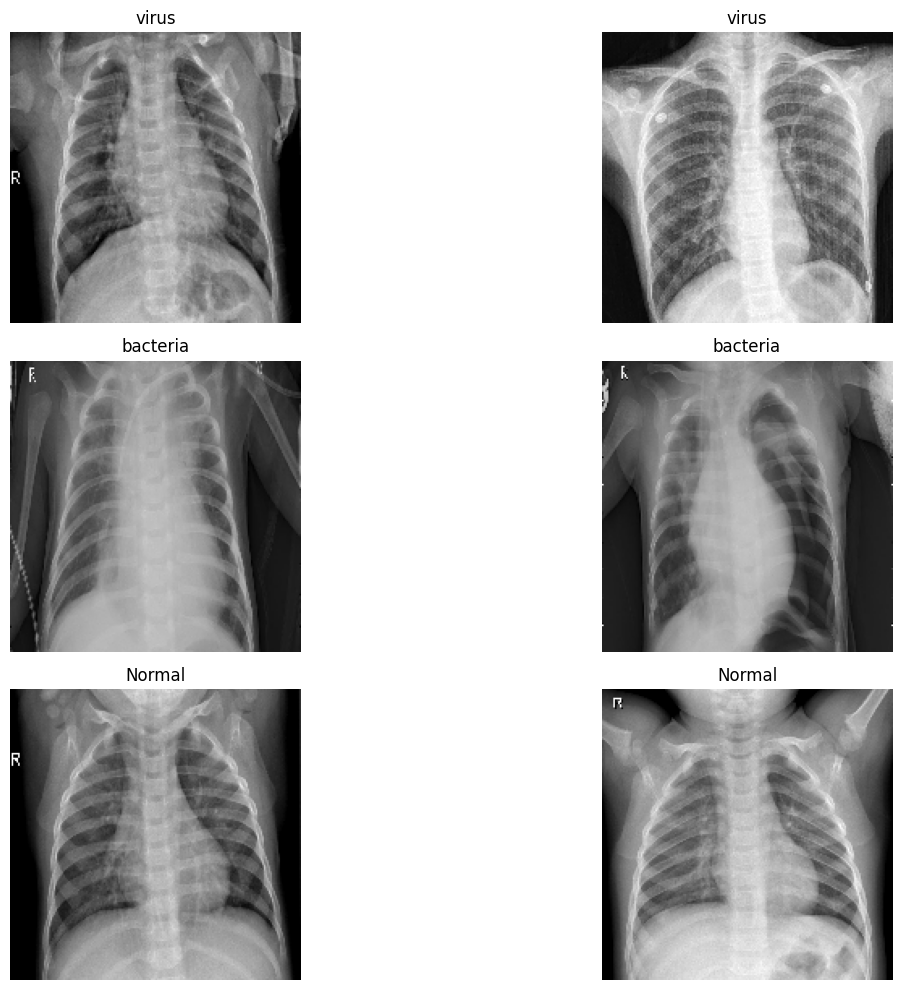

In [8]:

        # Plot the image on the corresponding subplot
        plt.subplot(len(class_names), 2, i*2 + j + 1)
        pimport matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Assuming train_data_dir is the path to your training data directory
class_names = os.listdir(train_data_dir)

# Create a matplotlib figure to display the images
plt.figure(figsize=(15, 10))

# Iterate over each class
for i, class_name in enumerate(class_names):
    # Get the path to the directory containing images for the current class
    class_dir = os.path.join(train_data_dir, class_name)
    # Get the list of image filenames in the class directory and select the first two
    class_images = os.listdir(class_dir)[:2]  # Select two images from each class

    # Iterate over each image in the class
    for j, image_name in enumerate(class_images):
        # Load the image using Keras image.load_img function and resize it to the target size
        image_path = os.path.join(class_dir, image_name)
        img = image.load_img(image_path, target_size=(img_height, img_width))
lt.imshow(img)
        plt.title(class_name)  # Set the title of the subplot to the class name
        plt.axis('off')  # Turn off axis labels

# Adjust the layout of subplots for better visualization
plt.tight_layout()
plt.show()

In [9]:
# Iterate over batches of images and labels in the training data generator
for image_batch, labels_batch in train_data:
    # Print the shape of the current batch of images
    print("Image batch shape:", image_batch.shape)
    # Print the shape of the current batch of labels
    print("Labels batch shape:", labels_batch.shape)
    # Break the loop after printing the first batch
    break

Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32, 3)


In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Reshape, Dense, GlobalMaxPooling2D, Add, Activation, Permute, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def cbam_attention(inputs, reduction_ratio=16):
    # Channel attention
    x = inputs
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = x.shape[channel_axis]
    shared_layer_one = Dense(channel // reduction_ratio, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu', use_bias=True)
    shared_layer_two = Dense(channel, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), use_bias=True)

    avg_pool = GlobalAveragePooling2D()(x)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(x)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

#     if tf.keras.backend.image_data_format() == "channels_first":
#         cbam_feature = Permute((3, 1, 2))(cbam_feature)

#     attention_feature = multiply([x, cbam_feature])

    # Spatial attention
    kernel_size = 7
    spatial_attention = Conv2D(1, (kernel_size, kernel_size), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), padding='same', activation='sigmoid', use_bias=False)(attention_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        spatial_attention = Permute((3, 1, 2))(spatial_attention)

    attention_feature = multiply([attention_feature, spatial_attention])
    return attention_feature

# Assuming visible is the input tensor
visible = Input(shape=(180, 180, 3))

# Build the model using the functional API
x = Conv2D(16, kernel_size=(3,3), activation='relu')(visible)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Apply CBAM attention
x = cbam_attention(x, 8)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(128, activation='relu')(x)

# Output Layer
output_layer = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=visible, outputs=output_layer)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 178, 178, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 89, 89, 16)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 87, 87, 32)   4640        max_pooling2d_18[0][0]           
____________________________________________________________________________________________

# **This code builds a Convolutional Neural Network (CNN) model with CBAM (Convolutional Block Attention Module) attention mechanism for image classification. **

In [47]:
# Compile the model
model.compile(
    optimizer='adam',  # Use Adam optimizer for training
    loss='categorical_crossentropy', #categorical cross-entropy loss function
    metrics=['accuracy']  # Monitor accuracy during training
)

In [48]:
# Train the model
history = model.fit(train_data,
      steps_per_epoch=batch_size,
      epochs=30,
      validation_data=valid_data,
      validation_steps=batch_size,
      verbose=1)

Epoch 1/30
32/32 [==============================] - 13s 405ms/step - loss: 1.2879 - acc: 0.3359 - val_loss: 1.2405 - val_acc: 0.3581
Epoch 2/30
32/32 [==============================] - 11s 356ms/step - loss: 1.2212 - acc: 0.3408 - val_loss: 1.2029 - val_acc: 0.3290
Epoch 3/30
32/32 [==============================] - 11s 355ms/step - loss: 1.1859 - acc: 0.3598 - val_loss: 1.1638 - val_acc: 0.3360
Epoch 4/30
32/32 [==============================] - 11s 357ms/step - loss: 1.1599 - acc: 0.3545 - val_loss: 1.1500 - val_acc: 0.3390
Epoch 5/30
32/32 [==============================] - 11s 345ms/step - loss: 1.1362 - acc: 0.3784 - val_loss: 1.1272 - val_acc: 0.3430
Epoch 6/30
32/32 [==============================] - 11s 345ms/step - loss: 1.1188 - acc: 0.3887 - val_loss: 1.1103 - val_acc: 0.3681
Epoch 7/30
32/32 [==============================] - 11s 352ms/step - loss: 1.0884 - acc: 0.4736 - val_loss: 1.0438 - val_acc: 0.4905
Epoch 8/30
32/32 [==============================] - 12s 361ms/step - 

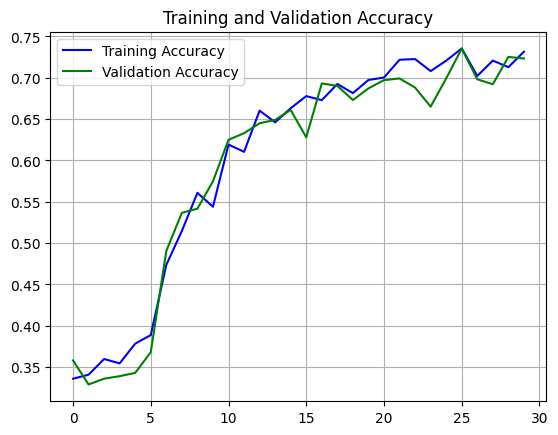

<Figure size 640x480 with 0 Axes>

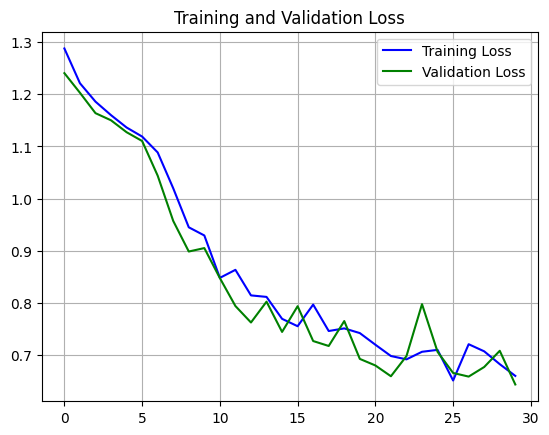

In [49]:
# Extracting training and validation accuracy and loss from the history object
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

#*Prediction*

In [50]:
# Get the filenames from the generator
fnames = test_data.filenames
 
# Get the ground truth from generator
ground_truth = test_data.classes
 
# Get the label to class mapping from the generator
label2index = test_data.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(test_data, steps=1,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_data.samples))

1/1 [==============================] - 0s 392ms/step
No of errors = 186/279


In [51]:
accuracy = ((test_data.samples-len(errors))/test_data.samples) * 100
accuracy

33.33333333333333